In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 

In [2]:
def index_classes(items):
    idx = {}
    for i in items:
        if (i not in idx):
            idx[i] = len(idx)
    return idx

class MiniImagenet(data.Dataset):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/mini_imagenet.py)
    **Description**
    The *mini*-ImageNet dataset was originally introduced by Vinyals et al., 2016.
    It consists of 60'000 colour images of sizes 84x84 pixels.
    The dataset is divided in 3 splits of 64 training, 16 validation, and 20 testing classes each containing 600 examples.
    The classes are sampled from the ImageNet dataset, and we use the splits from Ravi & Larochelle, 2017.
    **References**
    1. Vinyals et al. 2016. “Matching Networks for One Shot Learning.” NeurIPS.
    2. Ravi and Larochelle. 2017. “Optimization as a Model for Few-Shot Learning.” ICLR.
    **Arguments**
    * **root** (str) - Path to download the data.
    * **mode** (str, *optional*, default='train') - Which split to use.
        Must be 'train', 'validation', or 'test'.
    * **transform** (Transform, *optional*, default=None) - Input pre-processing.
    * **target_transform** (Transform, *optional*, default=None) - Target pre-processing.
    * **download** (bool, *optional*, default=False) - Download the dataset if it's not available.
    **Example**
    ~~~python
    ~~~
    """
    def __init__(
        self,
        root,
        mode='train',
        transform=None,
        target_transform=None):
        super(MiniImagenet, self).__init__()
        self.root = os.path.expanduser(root)
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        pickle_file = os.path.join(self.root, 'mini-imagenet-cache-' + mode + '.pkl')

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

   #     self.x = torch.from_numpy(self.data["image_data"]).permute(0, 3, 1, 2).float()
        self.x =self.data["image_data"]
        self.y = np.ones(len(self.x))

        # TODO Remove index_classes from here
        self.class_idx = index_classes(self.data['class_dict'].keys())
        for class_name, idxs in self.data['class_dict'].items():
            for idx in idxs:
                self.y[idx] = self.class_idx[class_name]

    def __getitem__(self, idx):
        data = self.x[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.y[idx]

    def __len__(self):
        return len(self.x)


In [3]:
import math
import torch.nn as nn
from kernel import CannyFilter,get_thin_kernels

In [4]:
transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_set=MiniImagenet(root="data/",mode='train',transform=transform)
torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [30000, 8400])


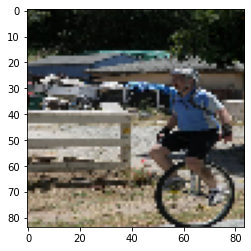

In [5]:
img=train_set[321][0]*0.5+0.5
plt.imshow(T.ToPILImage()(img))

In [6]:
for _ in range(5):
    img_idx=random.randint(0,len(train_set)-1)
    canny_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=False)
    blur_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
    img=train_set[img_idx][0]*0.5+0.5
    outputs=canny_kernel(img.unsqueeze(0))
    fig,ax=plt.subplots(ncols=4,figsize=(8,16))
    noblur_outputs=blur_kernel(img.unsqueeze(0))

    ax[0].imshow(T.ToPILImage()(img))
    ax[1].imshow(T.ToPILImage()(outputs[0][0]))
    ax[2].imshow(T.ToPILImage()(outputs[1][0]),cmap='gray')
    ax[3].imshow(T.ToPILImage()(noblur_outputs[1][0]),cmap='gray')


RuntimeError: weight should have at least three dimensions

In [7]:
thin_kernels = get_thin_kernels()
directional_kernels = np.stack(thin_kernels)

In [ ]:
directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)


In [27]:
directional_filter.weight = nn.Parameter(torch.from_numpy(directional_kernels).reshape(directional_filter.weight.shape))


In [8]:
import torchvision.models as models
model = models.resnet18(num_classes=64)